# 1.Version

In [1]:
import tensorflow as tf
print(tf.__version__)

#https://github.com/adapt-python/adapt/issues/118

2.13.1


# 2.Imports 

In [2]:
# Importing the required packages
import pandas as pd
import numpy as np
import os, shutil
import math
import matplotlib.pyplot as plt

import urllib.request
from tqdm import tqdm
from PIL import Image
import cv2
import pickle


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from keras.metrics import F1Score

import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential, Model #-> Versão 2.12
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D, GlobalAveragePooling2D, concatenate #-> Versão 2.12
from tensorflow.keras.optimizers import RMSprop, Adam #-> Versão 2.12
from tensorflow.keras.applications import VGG16, ResNet101, ResNet101V2, InceptionV3
import keras.backend as K
from tensorflow.keras.models import load_model 
from tensorflow.keras.utils import to_categorical


- **md5hash**: A unique identifier for each image.
- **fitzpatrick_scale**: The Fitzpatrick scale value for the skin type in the image.
- **fitzpatrick_centaur**: Another scale related to the Fitzpatrick scale, potentially adjusted or annotated differently.
- **label**: The target variable indicating the skin condition diagnosed in the image.
- **nine_partition_label** and **three_partition_label**: These columns seem to categorize conditions into broader groups.
- **qc**: A column that might relate to quality control or other annotations, which is empty in the first few rows.
- **url**: The URL of the image of the skin lesion.
- **url_alphanum**: A version of the URL with only alphanumeric characters, likely for easier processing or identification.


In [3]:
# Getting the current working directory
directory = os.getcwd()
directory

'c:\\Users\\Filipe\\VSCODE PROJECTS\\project_DL'

# 3.Images DownLoad and Preprocessing

In [5]:
df = pd.read_csv('c:\\Users\\Filipe\\VSCODE PROJECTS\\project_DL\\fitzpatrick17k.csv', sep=',')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16577 entries, 0 to 16576
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   md5hash                16577 non-null  object
 1   fitzpatrick_scale      16577 non-null  int64 
 2   fitzpatrick_centaur    16577 non-null  int64 
 3   label                  16577 non-null  object
 4   nine_partition_label   16577 non-null  object
 5   three_partition_label  16577 non-null  object
 6   qc                     504 non-null    object
 7   url                    16536 non-null  object
 8   url_alphanum           16577 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.1+ MB


In [7]:
df['url'].isna().sum()

41

In [8]:
# Dropping the rows with missing values
df.dropna(subset=['url'], inplace=True)

In [9]:
def download_images_and_check_missing(df, target_dir): 
    total_missing_url = 0
    total_url_not_found = 0
    total_failed_downloads = 0
    total_downloaded = 0

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'
    }

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        if pd.isnull(row['url']):
            total_missing_url += 1
            continue
        
        url = row['url']
        filename = os.path.join(target_dir, f"{row['md5hash']}.jpg")

        if os.path.exists(filename):
            total_downloaded += 1
            continue

        req = urllib.request.Request(url, headers=headers)

        try:
            with urllib.request.urlopen(req) as response, open(filename, 'wb') as out_file:
                data = response.read()
                out_file.write(data)
                total_downloaded += 1
        except urllib.error.HTTPError as e:
            if e.code == 404:
                total_url_not_found += 1
                print(f"URL not found {url}, skipping.")
            else:
                total_failed_downloads += 1
                print(f"Failed to download {url}: HTTP Error {e.code}")
        except Exception as e:
            total_failed_downloads += 1
            print(f"Failed to download {url}: {str(e)}")

    print(f"Total de imagens com URL faltando: {total_missing_url}")
    print(f"Total de URLs não encontradas (HTTP 404): {total_url_not_found}")
    print(f"Total de falhas no download: {total_failed_downloads}")
    print(f"Total de imagens baixadas ou já presentes: {total_downloaded}")

# Supondo que 'df' é o seu DataFrame e 'images' é o seu diretório de destino
download_images_and_check_missing(df, 'images')


 76%|███████▌  | 12591/16536 [00:02<00:00, 6355.31it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=6724: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>
Failed to download http://atlasdermatologico.com.br/img?imageId=4030: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 80%|███████▉  | 13227/16536 [00:05<00:04, 708.79it/s] 

Failed to download http://atlasdermatologico.com.br/img?imageId=5399: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>
Failed to download http://atlasdermatologico.com.br/img?imageId=4505: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 83%|████████▎ | 13679/16536 [00:06<00:05, 519.52it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=8362: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>
Failed to download http://atlasdermatologico.com.br/img?imageId=4031: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 85%|████████▍ | 14004/16536 [00:08<00:06, 373.69it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=8363: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 90%|████████▉ | 14879/16536 [00:09<00:02, 565.48it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=2767: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


 92%|█████████▏| 15238/16536 [00:10<00:02, 524.41it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=2766: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>


100%|██████████| 16536/16536 [00:11<00:00, 1454.19it/s]

Failed to download http://atlasdermatologico.com.br/img?imageId=8364: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>
Total de imagens com URL faltando: 0
Total de URLs não encontradas (HTTP 404): 0
Total de falhas no download: 10
Total de imagens baixadas ou já presentes: 16526


Since we have 41 missing URLs and 10 that aren't valid we are going to drop this rows.

In [10]:
invalid_urls = [
    "http://atlasdermatologico.com.br/img?imageId=6724",
    "http://atlasdermatologico.com.br/img?imageId=4030",
    "http://atlasdermatologico.com.br/img?imageId=5399",
    "http://atlasdermatologico.com.br/img?imageId=4505",
    "http://atlasdermatologico.com.br/img?imageId=8362",
    "http://atlasdermatologico.com.br/img?imageId=4031",
    "http://atlasdermatologico.com.br/img?imageId=8363",
    "http://atlasdermatologico.com.br/img?imageId=2767",
    "http://atlasdermatologico.com.br/img?imageId=2766",
    "http://atlasdermatologico.com.br/img?imageId=8364"
]

df = df[~df['url'].isin(invalid_urls)]

In [12]:
# Path to the directory containing the images
images_dir = 'c:\\Users\\Filipe\\VSCODE PROJECTS\\project_DL\\images'

# List of problematic images
problematic_images = []

# Verify the integrity of each image
for filename in tqdm(os.listdir(images_dir)):
    if not filename.endswith('.jpg'):  # Ignore non-image files
        continue
    
    try:
        img_path = os.path.join(images_dir, filename)
        with Image.open(img_path) as img:
            img.verify()  # Try to open the image and check for any errors
    except Exception as e:
        print(f"Erro ao verificar a imagem {filename}: {e}")
        problematic_images.append(filename)

# Print the total number of problematic images
print(f"Total de imagens problemáticas: {len(problematic_images)}")


  0%|          | 0/16526 [00:00<?, ?it/s]

100%|██████████| 16526/16526 [00:11<00:00, 1499.71it/s]

Total de imagens problemáticas: 0


In [13]:
base_dir = "images"

# Define the subdirectories
train_dir = "POPULATION\\train"
val_dir = "POPULATION\\val"
test_dir = "POPULATION\\test"

# Check if directories already exist
if not (os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir)):
    # Create the directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Split the data into train, validation, and test sets
    train_ratio = 0.8
    val_ratio = 0.1
    test_ratio = 0.1

    df_train_val, df_test = train_test_split(df, test_size=test_ratio, stratify=df['label'], random_state=42)
    df_train, df_val = train_test_split(df_train_val, test_size=val_ratio/(train_ratio+val_ratio), stratify=df_train_val['label'], random_state=42)

    # Function to copy images to respective directories
    def copy_images(df, dest_dir):
        for _, row in df.iterrows():
            file_name = f"{row['md5hash']}.jpg"
            source_path = os.path.join(base_dir, file_name)

            if not os.path.isfile(source_path):
                print(f"File not found: {source_path}")
                continue

            label_dir = os.path.join(dest_dir, row['label'])
            os.makedirs(label_dir, exist_ok=True)

            destination_path = os.path.join(label_dir, file_name)
            shutil.copy(source_path, destination_path)

    copy_images(df_train, train_dir)
    copy_images(df_val, val_dir)
    copy_images(df_test, test_dir)


# Function to count images in a directory
def count_images(dir_path):
    count = 0
    for _, dirs, files in os.walk(dir_path):
        count += len(files)
    return count

print(f"Total images in training: {count_images(train_dir)}")
print(f"Total images in validation: {count_images(val_dir)}")
print(f"Total images in testing: {count_images(test_dir)}")

Total images in training: 13220
Total images in validation: 1653
Total images in testing: 1653


Slide 21 Class_3_MLF
- the lower the loss on training data, the lower the loss on test data. While this is happening, your model is said to be underfit: there is still progress to be made; the network hasn’t yet modeled all relevant patterns in the training data. 

- But after a certain number of iterations on the training data, generalization stops improving, and validation metrics stall and then begin to degrade: the model is starting to overfit. That is, it’s beginning to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.


# 4.Functions

In [14]:
def training_plots(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1_metric']  
    val_f1 = history.history['val_f1_metric'] 

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation F1 score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1, 'bo', label='Training F1 Score')
    plt.plot(epochs, val_f1, 'b', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures

- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally

- rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such 
values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.

- shear_range is for randomly applying shearing transformations

- zoom_range is for randomly zooming inside pictures

- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [15]:
import matplotlib.pyplot as plt

def training_plots_1(history):
    # Já é um dicionário, não precisa de '.history'
    acc = history['categorical_accuracy']
    val_acc = history['val_categorical_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    f1 = history['f1_metric']
    val_f1 = history['val_f1_metric']
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation F1 score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1, 'bo', label='Training F1 Score')
    plt.plot(epochs, val_f1, 'b', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [16]:
def evaluate_model(model, train_generator, validation_generator, test_generator):
    # Evaluate the model on the training set
    train_results = model.evaluate(train_generator, verbose=0)
    train_loss, train_categorical_accuracy, train_f1_metric = train_results  # Adjusted for additional metric
    
    # Evaluate the model on the validation set
    validation_results = model.evaluate(validation_generator, verbose=0)
    validation_loss, validation_categorical_accuracy, validation_f1_metric = validation_results  # Adjusted for additional metric

    # Evaluate the model on the validation set
    test_results = model.evaluate(test_generator, verbose=0)
    test_loss, test_categorical_accuracy, test_f1_metric = test_results  # Adjusted for additional metric
    
    # Print Loss, Categorical Accuracy, and Weighted F1 Score for Training and Validation Sets
    print(f"Training Loss: {train_loss}\nTraining Categorical Accuracy: {train_categorical_accuracy}\nTraining Weighted F1-score: {train_f1_metric}")
    print(f"Validation Loss: {validation_loss}\nValidation Categorical Accuracy: {validation_categorical_accuracy}\nValidation Weighted F1-score: {validation_f1_metric}")
    print(f"Test Loss: {test_loss}\nTest Categorical Accuracy: {test_categorical_accuracy}\nTest Weighted F1-score: {test_f1_metric}")


https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras/45305384#45305384

In [17]:
#https://stackoverflow.com/questions/59963911/how-to-write-a-custom-f1-loss-function-with-weighted-average-for-keras
from tensorflow.keras import backend as K

def f1_metric(true, pred):
    # predLabels = K.argmax(pred, axis=-1)  # Uncomment these lines if 'pred' needs to be converted
    # pred = K.one_hot(predLabels, 4)      # from probabilities to one-hot encoded values

    ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)
    
    return weighted_f1  # Return the weighted F1 score directly


# 5.Rescaling

https://www.ibm.com/topics/underfitting

Identifying overfitting can be more difficult than underfitting because unlike underfitting, the training data performs at high accuracy in an overfitted model. To assess the accuracy of an algorithm, a technique called k-fold cross-validation is typically used.


In [18]:
# # Rescale all images by 1./255
# # CNNs_TF2 Slide 96
# #https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],  # Adjust brightness randomly between 0.5 and 1.5
    channel_shift_range=20  # Randomly shift channels by up to 20 intensity units
    )

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
# # Rescale all images by 1./255
# # CNNs_TF2 Slide 96
# #https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# from keras.layers import CenterCrop

# train_datagen = ImageDataGenerator(rescale=1./255 #Need to divide by 255 to normalize the pixel values [0, 255] to [0, 1]
#                                    , rotation_range=30 #Rotate the image by 30 degrees
#                                    , width_shift_range=0.2 #Shift the image horizontally by 20%
#                                    , height_shift_range=0.2 #Shift the image vertically by 20%
#                                    , shear_range=0.2 #Shear the image by 20%
#                                    , zoom_range=0.2 #Zoom in by 20%
#                                    #, preprocessing_function=CenterCrop(height, width)
#                                    , horizontal_flip=True) #Flip the image horizontally
# validation_datagen = ImageDataGenerator(rescale=1./255)

# #center crop


# 6.Train, Val and Test Generator

In [19]:
# CNNs_TF2 Slide 96
#150x150 RGB images with shape (20, 150, 150, 3)
train_generator15020 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle = True)
#150x150 RGB images with shape (32, 150, 150, 3)
train_generator15032 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = True)
#227x227 RGB images with shape (64, 227, 227, 3)
train_generator22764 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='categorical',
    shuffle = True)
#224x224 RGB images with shape (64, 224, 224, 3)
train_generator22464 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle = True)

#224x224 RGB images with shape (256, 224, 224, 3)
train_generator224256 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=256,
    class_mode='categorical',
    shuffle = True)


Found 13220 images belonging to 114 classes.
Found 13220 images belonging to 114 classes.
Found 13220 images belonging to 114 classes.
Found 13220 images belonging to 114 classes.
Found 13220 images belonging to 114 classes.


In [20]:
#150x150 RGB images with shape (20, 150, 150, 3)
validation_generator15020 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle = False)

#150x150 RGB images with shape (32, 150, 150, 3)
validation_generator15032 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = False)
#227x227 RGB images with shape (64, 227, 227, 3)
validation_generator22764 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='categorical',
    shuffle = False)
#224x224 RGB images with shape (64, 224, 224, 3)
validation_generator22464 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle = False)
#224x224 RGB images with shape (256, 224, 224, 3)
validation_generator224256 = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=256,
    class_mode='categorical',
    shuffle = True)

Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.


In [21]:
#150x150 RGB images with shape (20, 150, 150, 3)
test_generator15020 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle = False)

#150x150 RGB images with shape (32, 150, 150, 3)
test_generator15032 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle = False)
#227x227 RGB images with shape (64, 227, 227, 3)
test_generator22764 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(227, 227),
    batch_size=64,
    class_mode='categorical',
    shuffle = False)
#224x224 RGB images with shape (64, 224, 224, 3)
test_generator22464 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle = False)
#224x224 RGB images with shape (256, 224, 224, 3)
test_generator224256 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=256,
    class_mode='categorical',
    shuffle = False)



Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.
Found 1653 images belonging to 114 classes.


In [22]:
# For training generator
train_samples = train_generator15020.samples
train_batch_size = train_generator15020.batch_size
train_image_shape = train_generator15020.image_shape

print(f"Training: Total samples: {train_samples}, Batch size: {train_batch_size}, Image shape: {train_image_shape}")

# For validation generator
val_samples = validation_generator15020.samples
val_batch_size = validation_generator15020.batch_size
val_image_shape = validation_generator15020.image_shape

print(f"Validation: Total samples: {val_samples}, Batch size: {val_batch_size}, Image shape: {val_image_shape}")

# For test generator
test_samples = test_generator15020.samples
test_batch_size = test_generator15020.batch_size
test_image_shape = test_generator15020.image_shape

print(f"Test: Total samples: {test_samples}, Batch size: {test_batch_size}, Image shape: {test_image_shape}")
#(13221,64,64,3) 3 13221 images of 64x64 px and 3 color channels
#RGB 
#Go from 0 to 255, red is (255,0,0), green is (0,255,0) and blue is (0,0,255)

Training: Total samples: 13220, Batch size: 20, Image shape: (150, 150, 3)
Validation: Total samples: 1653, Batch size: 20, Image shape: (150, 150, 3)
Test: Total samples: 1653, Batch size: 20, Image shape: (150, 150, 3)


In [23]:
# For training generator
train_samples = train_generator15032.samples
train_batch_size = train_generator15032.batch_size
train_image_shape = train_generator15032.image_shape

print(f"Training: Total samples: {train_samples}, Batch size: {train_batch_size}, Image shape: {train_image_shape}")

# For validation generator
val_samples = validation_generator15032.samples
val_batch_size = validation_generator15032.batch_size
val_image_shape = validation_generator15032.image_shape

print(f"Validation: Total samples: {val_samples}, Batch size: {val_batch_size}, Image shape: {val_image_shape}")

# For test generator
test_samples = test_generator15032.samples
test_batch_size = test_generator15032.batch_size
test_image_shape = test_generator15032.image_shape

print(f"Test: Total samples: {test_samples}, Batch size: {test_batch_size}, Image shape: {test_image_shape}")

Training: Total samples: 13220, Batch size: 32, Image shape: (150, 150, 3)
Validation: Total samples: 1653, Batch size: 32, Image shape: (150, 150, 3)
Test: Total samples: 1653, Batch size: 32, Image shape: (150, 150, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


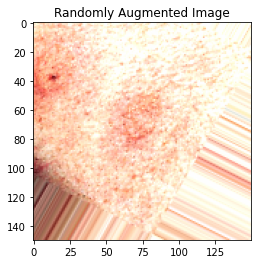

In [24]:
# Retrieve a batch of images and labels
images, labels = next(train_generator15020)

# Display the first image in the batch
plt.imshow(images[10])
plt.title('Randomly Augmented Image')
plt.show()

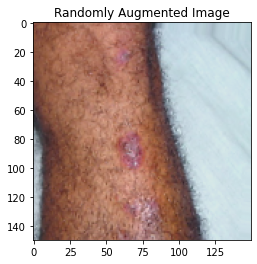

In [25]:
# Retrieve a batch of images and labels
images, labels = next(train_generator15032)

# Display the first image in the batch
plt.imshow(images[10])
plt.title('Randomly Augmented Image')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


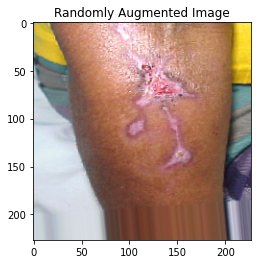

In [26]:
# Retrieve a batch of images and labels
images, labels = next(train_generator22764)

# Display the first image in the batch
plt.imshow(images[10])
plt.title('Randomly Augmented Image')
plt.show()

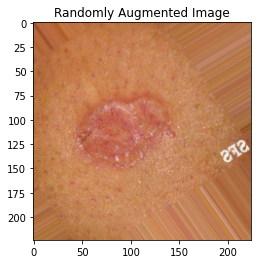

In [27]:
# Retrieve a batch of images and labels
images, labels = next(train_generator22464)

# Display the first image in the batch
plt.imshow(images[10])
plt.title('Randomly Augmented Image')
plt.show()

# 7.CallBacks - Early Stopping

https://datascience.stackexchange.com/questions/26833/is-there-away-to-change-the-metric-used-by-the-early-stopping-callback-in-keras

https://stackoverflow.com/questions/50003595/earlystopping-is-ignoring-my-custom-metrics-defined-keras-model

In [28]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_loss', 
        mode= 'min'),
]

# 9.Pre-Trained Models

## 9.1 VGG16

In [34]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(114, activation='softmax')(x) 

## Create model
vgg16 = Model(inputs=base_model.input, outputs=predictions)

# Compile model
vgg16.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', f1_metric])


# Train the model
history_vgg16 = vgg16.fit(train_generator224256,
                  epochs=20,
                  callbacks = callbacks_list,
                  validation_data=validation_generator224256)


Epoch 1/20
52/52 [==============================] - 1035s 20s/step - loss: 4.6520 - accuracy: 0.0466 - f1_metric: 0.0155 - val_loss: 4.3923 - val_accuracy: 0.0665 - val_f1_metric: 0.0195
Epoch 2/20
52/52 [==============================] - 1025s 20s/step - loss: 4.3656 - accuracy: 0.0626 - f1_metric: 0.0216 - val_loss: 4.2854 - val_accuracy: 0.0744 - val_f1_metric: 0.0250
Epoch 3/20
52/52 [==============================] - 1025s 20s/step - loss: 4.2714 - accuracy: 0.0720 - f1_metric: 0.0254 - val_loss: 4.1449 - val_accuracy: 0.0956 - val_f1_metric: 0.0301
Epoch 4/20
52/52 [==============================] - 1025s 20s/step - loss: 4.1729 - accuracy: 0.0902 - f1_metric: 0.0301 - val_loss: 4.0695 - val_accuracy: 0.1016 - val_f1_metric: 0.0361
Epoch 5/20
52/52 [==============================] - 1026s 20s/step - loss: 4.0910 - accuracy: 0.0992 - f1_metric: 0.0350 - val_loss: 3.9963 - val_accuracy: 0.1125 - val_f1_metric: 0.0419
Epoch 6/20
52/52 [==============================] - 1024s 20s/ste

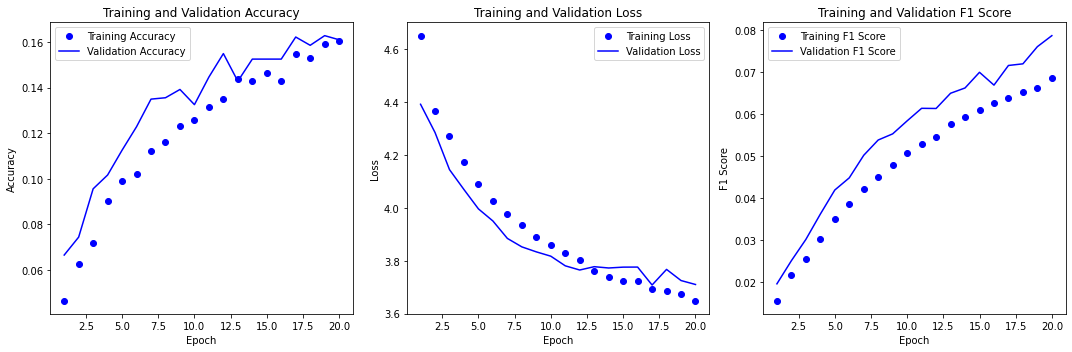

Training Loss: 3.608254909515381
Training Categorical Accuracy: 0.16921330988407135
Training Weighted F1-score: 0.0701589360833168
Validation Loss: 3.7102320194244385
Validation Categorical Accuracy: 0.16091954708099365
Validation Weighted F1-score: 0.07713942974805832
Test Loss: 3.6970713138580322
Test Categorical Accuracy: 0.16333937644958496
Test Weighted F1-score: 0.12020973116159439


In [44]:
training_plots(history_vgg16)
evaluate_model(vgg16, train_generator224256, validation_generator224256, test_generator224256)

## 9.2 GoogleNet (Inception V3)

In [29]:
# Load pre-trained InceptionV3 model without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(114, activation='softmax')(x)

# Create model
gnet = Model(inputs=base_model.input, outputs=predictions)

# Compile model
gnet.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', f1_metric])

# Train the model
history_gnet = gnet.fit(train_generator224256,
          epochs=20,
          callbacks = callbacks_list,
          validation_data=validation_generator224256)



Epoch 1/20
52/52 [==============================] - 373s 7s/step - loss: 4.4260 - categorical_accuracy: 0.0668 - f1_metric: 0.0213 - val_loss: 4.1493 - val_categorical_accuracy: 0.1053 - val_f1_metric: 0.0308
Epoch 2/20
52/52 [==============================] - 357s 7s/step - loss: 3.9980 - categorical_accuracy: 0.1190 - f1_metric: 0.0401 - val_loss: 3.8862 - val_categorical_accuracy: 0.1397 - val_f1_metric: 0.0483
Epoch 3/20
52/52 [==============================] - 353s 7s/step - loss: 3.7510 - categorical_accuracy: 0.1518 - f1_metric: 0.0588 - val_loss: 3.7171 - val_categorical_accuracy: 0.1652 - val_f1_metric: 0.0611
Epoch 4/20
52/52 [==============================] - 350s 7s/step - loss: 3.5962 - categorical_accuracy: 0.1753 - f1_metric: 0.0723 - val_loss: 3.6275 - val_categorical_accuracy: 0.1797 - val_f1_metric: 0.0718
Epoch 5/20
52/52 [==============================] - 345s 7s/step - loss: 3.4929 - categorical_accuracy: 0.1922 - f1_metric: 0.0822 - val_loss: 3.5597 - val_categori

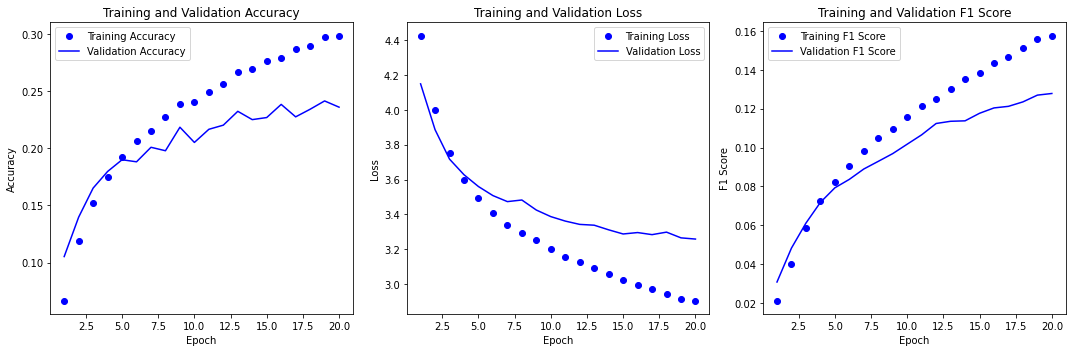

Training Loss: 2.834120273590088
Training Categorical Accuracy: 0.31195157766342163
Training Weighted F1-score: 0.16265569627285004
Validation Loss: 3.258148431777954
Validation Categorical Accuracy: 0.23593465983867645
Validation Weighted F1-score: 0.1281789392232895
Test Loss: 3.265758752822876
Test Categorical Accuracy: 0.24682395160198212
Test Weighted F1-score: 0.19084613025188446


In [30]:
training_plots(history_gnet)
evaluate_model(gnet, train_generator224256, validation_generator224256, test_generator224256)

## 9.2.1 GoogleNet (Inception V3) with dropout

In [31]:
# Load pre-trained InceptionV3 model without top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers with dropout
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)  # Add dropout with a rate of 0.1 
predictions = Dense(114, activation='softmax')(x) 

# Create model
gnetdp = Model(inputs=base_model.input, outputs=predictions)

# Compile model
gnetdp.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', f1_metric])

# Train the model
history_gnetdp = gnetdp.fit(train_generator224256,
          epochs=20,
          callbacks = callbacks_list,
          validation_data=validation_generator224256)

Epoch 1/20
52/52 [==============================] - 344s 7s/step - loss: 4.4538 - categorical_accuracy: 0.0590 - f1_metric: 0.0199 - val_loss: 4.1779 - val_categorical_accuracy: 0.0992 - val_f1_metric: 0.0291
Epoch 2/20
52/52 [==============================] - 344s 7s/step - loss: 4.0695 - categorical_accuracy: 0.1070 - f1_metric: 0.0361 - val_loss: 3.9191 - val_categorical_accuracy: 0.1295 - val_f1_metric: 0.0434
Epoch 3/20
52/52 [==============================] - 337s 6s/step - loss: 3.8688 - categorical_accuracy: 0.1331 - f1_metric: 0.0490 - val_loss: 3.7844 - val_categorical_accuracy: 0.1494 - val_f1_metric: 0.0541
Epoch 4/20
52/52 [==============================] - 334s 6s/step - loss: 3.7137 - categorical_accuracy: 0.1590 - f1_metric: 0.0618 - val_loss: 3.6635 - val_categorical_accuracy: 0.1621 - val_f1_metric: 0.0652
Epoch 5/20
52/52 [==============================] - 336s 6s/step - loss: 3.6196 - categorical_accuracy: 0.1657 - f1_metric: 0.0690 - val_loss: 3.6356 - val_categori

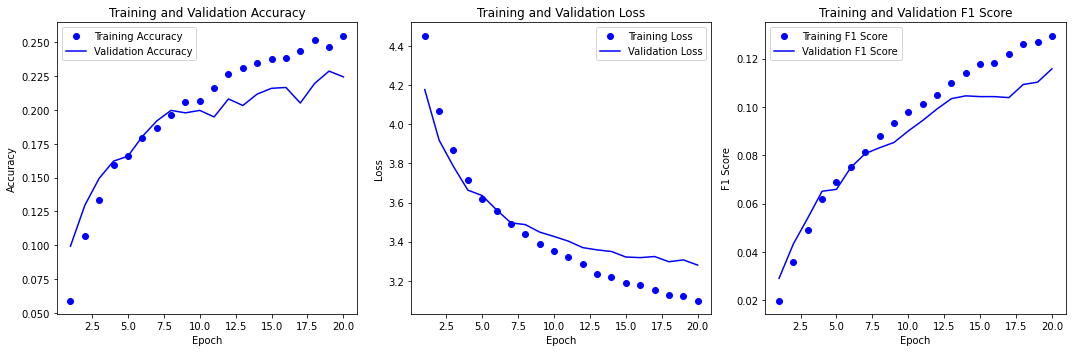

Training Loss: 2.927945613861084
Training Categorical Accuracy: 0.2962934970855713
Training Weighted F1-score: 0.14170382916927338
Validation Loss: 3.2800583839416504
Validation Categorical Accuracy: 0.22444041073322296
Validation Weighted F1-score: 0.11529457569122314
Test Loss: 3.2567036151885986
Test Categorical Accuracy: 0.22625529766082764
Test Weighted F1-score: 0.17657378315925598


In [32]:
training_plots(history_gnetdp)
evaluate_model(gnetdp, train_generator224256, validation_generator224256, test_generator224256)

## 9.3 ResNet101V2 - W/ 0.5 Dropout

https://keras.io/api/applications/resnet/#resnet101v2-function

In [46]:
# Load pre-trained ResNet101V2 model without top layers
base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers with dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x) 
predictions = Dense(114, activation='softmax')(x)

# Create model
resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile model
resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy', f1_metric])

history_resnet = resnet.fit(
    train_generator22464,
    steps_per_epoch=206,  
    epochs=20,            
    callbacks=callbacks_list,
    validation_data=validation_generator22464,
    validation_steps=25  
)

Epoch 1/20
206/206 [==============================] - 889s 4s/step - loss: 4.5990 - categorical_accuracy: 0.0531 - f1_metric: 0.0238 - val_loss: 4.1696 - val_categorical_accuracy: 0.1088 - val_f1_metric: 0.0518
Epoch 2/20
206/206 [==============================] - 875s 4s/step - loss: 4.1980 - categorical_accuracy: 0.0993 - f1_metric: 0.0389 - val_loss: 3.9064 - val_categorical_accuracy: 0.1419 - val_f1_metric: 0.0805
Epoch 3/20
206/206 [==============================] - 875s 4s/step - loss: 3.9579 - categorical_accuracy: 0.1251 - f1_metric: 0.0567 - val_loss: 3.7224 - val_categorical_accuracy: 0.1756 - val_f1_metric: 0.1060
Epoch 4/20
206/206 [==============================] - 870s 4s/step - loss: 3.8189 - categorical_accuracy: 0.1484 - f1_metric: 0.0699 - val_loss: 3.6012 - val_categorical_accuracy: 0.1931 - val_f1_metric: 0.1226
Epoch 5/20
206/206 [==============================] - 875s 4s/step - loss: 3.6793 - categorical_accuracy: 0.1681 - f1_metric: 0.0818 - val_loss: 3.5097 - va

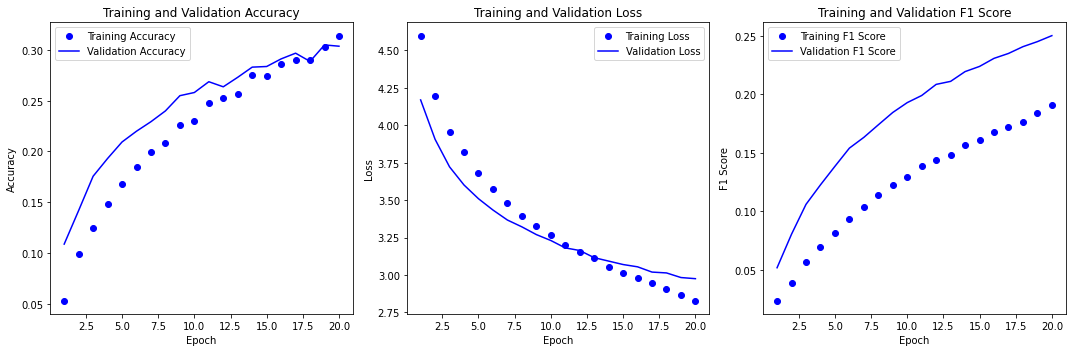

Training Loss: 2.5529489517211914
Training Categorical Accuracy: 0.38600605726242065
Training Weighted F1-score: 0.21076659858226776
Validation Loss: 2.9977006912231445
Validation Categorical Accuracy: 0.3006654679775238
Validation Weighted F1-score: 0.24636466801166534
Test Loss: 3.052731990814209
Test Categorical Accuracy: 0.2928009629249573
Test Weighted F1-score: 0.24062380194664001


In [47]:
training_plots(history_resnet)
evaluate_model(resnet, train_generator22464, validation_generator22464, test_generator22464)